In [2]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
from skimage.transform import pyramid_gaussian, pyramid_expand
import skimage
from collections import defaultdict
import scipy
import ipywidgets as widgets
from ipywidgets import interact

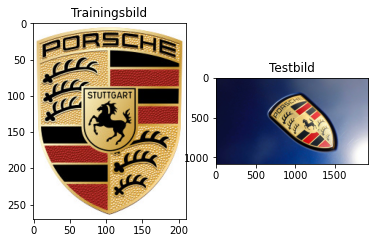

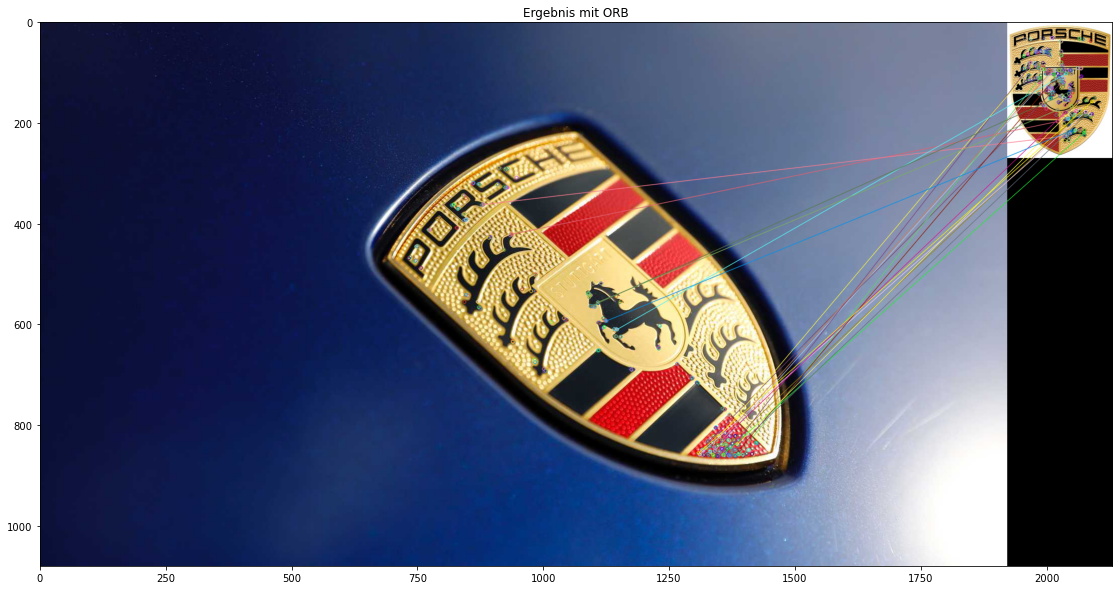

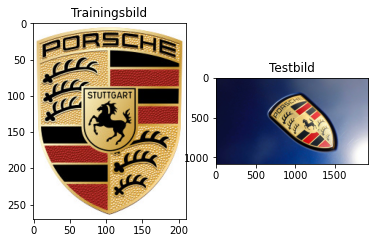

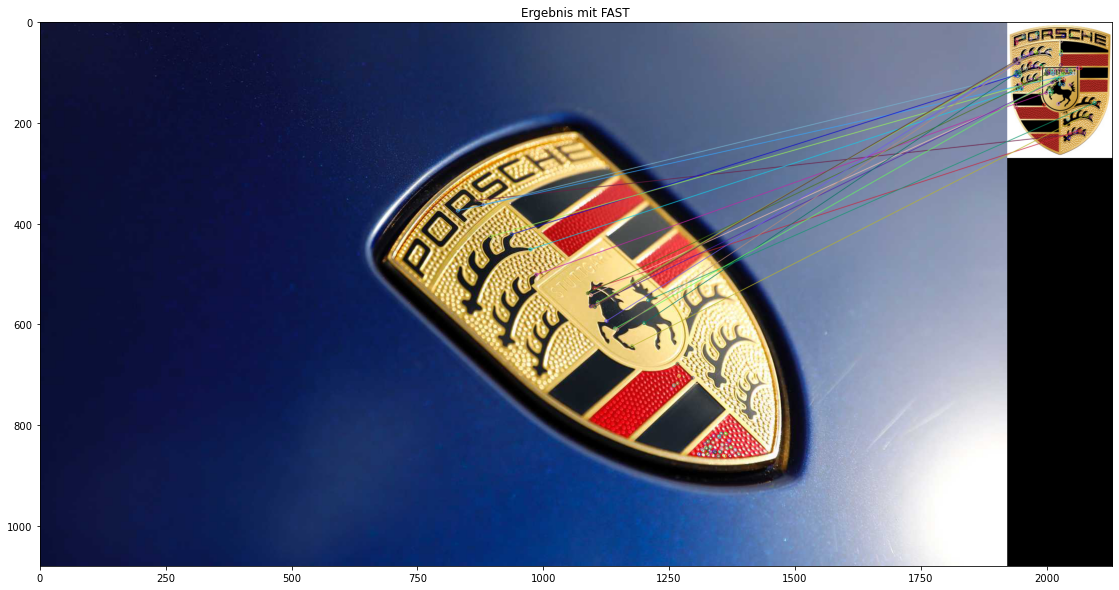

Found  14  keypoints


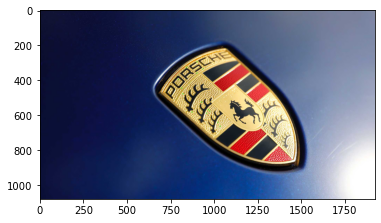

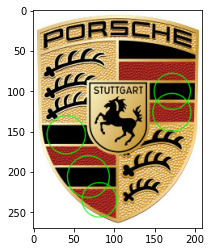

In [3]:
query_img = cv.cvtColor(cv.imread('./img/Porsche_Taycan_Aussen3.jpg'), cv.COLOR_BGR2RGB)
train_img = cv.cvtColor(cv.imread('./img/Porsche_Wappen.jpg'), cv.COLOR_BGR2RGB)
query_img_gray = cv.cvtColor(query_img,cv.COLOR_BGR2GRAY) 
train_img_gray = cv.cvtColor(train_img, cv.COLOR_BGR2GRAY) 


### ORB #################################################################################
orb = cv.ORB_create()
#sift = cv.xfeatures2d.SIFT_create()

# Erkenne Merkmale mit ORB
query_keypoints_orb, query_descriptors_orb = orb.detectAndCompute(query_img_gray,None) 
train_keypoints_orb, train_descriptors_orb = orb.detectAndCompute(train_img_gray,None) 
 
# Finde Übereinstimmungen der Merkmale 
matcher = cv.BFMatcher() 
matches = matcher.match(query_descriptors_orb,train_descriptors_orb) 

# Zeichne Übereinstimmungen auf finalem Bild
out_img_orb = cv.drawMatches(query_img, query_keypoints_orb, train_img, train_keypoints_orb, matches[:20],None) 

plt.subplot(1,2,1); plt.imshow(train_img); plt.title('Trainingsbild')
plt.subplot(1,2,2); plt.imshow(query_img); plt.title('Testbild')
plt.show()

plt.figure(figsize=(20,10)); 
plt.imshow(out_img_orb); plt.title('Ergebnis mit ORB')
plt.show()

### FAST + BRISK ################################################################################
fast = cv.FastFeatureDetector_create(threshold=150)

# Erkenne Merkmale mit FAST
query_keypoints_fast = fast.detect(query_img_gray)
train_keypoints_fast = fast.detect(train_img_gray) 

# Sonderschritt: berechne Deskriptoren mit BRISK
br = cv.BRISK_create()
query_keypoints_fast, query_descriptors_fast = br.compute(query_img_gray, query_keypoints_fast)
train_keypoints_fast, train_descriptors_fast = br.compute(train_img_gray, train_keypoints_fast)
 
# Finde Übereinstimmungen der Merkmale 
matcher = cv.BFMatcher() 
matches = matcher.match(query_descriptors_fast,train_descriptors_fast) 

# Zeichne Übereinstimmungen auf finalem Bild
out_img_fast = cv.drawMatches(query_img, query_keypoints_fast, train_img, train_keypoints_fast, matches[:20],None) 

plt.subplot(1,2,1); plt.imshow(train_img); plt.title('Trainingsbild')
plt.subplot(1,2,2); plt.imshow(query_img); plt.title('Testbild')
plt.show()

plt.figure(figsize=(20,10)); 
plt.imshow(out_img_fast); plt.title('Ergebnis mit FAST')
plt.show()

### Blob-Detection ##############################################################################
blob_params = cv.SimpleBlobDetector_Params()
blob_params.minThreshold=0
blob_params.maxThreshold=255
blob_detector = cv.SimpleBlobDetector_create(blob_params)


# Erkenne Merkmale mit Blob
query_keypoints_blob = blob_detector.detect(query_img_gray)
train_keypoints_blob = blob_detector.detect(train_img_gray) 

# zeichne Keypoints
print('Found ', len(query_keypoints_blob), ' keypoints')
out_keypoints_blob_query = cv.drawKeypoints(query_img, query_keypoints_blob, np.array([]), (0,255,0), cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
out_keypoints_blob_train = cv.drawKeypoints(train_img, train_keypoints_blob, np.array([]), (0,255,0), cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(out_keypoints_blob_query); plt.show()
plt.imshow(out_keypoints_blob_train); plt.show()

# Sonderschritt: berechne Deskriptoren mit BRISK
br = cv.BRISK_create()
query_keypoints_blob, query_descriptors_blob = br.compute(query_img_gray, query_keypoints_blob)
train_keypoints_blob, train_descriptors_blob = br.compute(train_img_gray, train_keypoints_blob)
 
# Finde Übereinstimmungen der Merkmale 
#matcher = cv.BFMatcher() 
#matches = matcher.match(query_descriptors_blob,train_descriptors_blob) 

# Zeichne Übereinstimmungen auf finalem Bild
#out_img_blob = cv.drawMatches(query_img, query_keypoints_blob, train_img, train_keypoints_blob, matches[:20],None) 

#plt.subplot(1,2,1); plt.imshow(train_img); plt.title('Trainingsbild')
#plt.subplot(1,2,2); plt.imshow(query_img); plt.title('Testbild')
#plt.show()

#plt.figure(figsize=(20,10)); 
#plt.imshow(out_img_blob); plt.title('Ergebnis mit FAST')
#plt.show()





# Stereo-Vision
https://docs.opencv.org/3.4/dd/d53/tutorial_py_depthmap.html

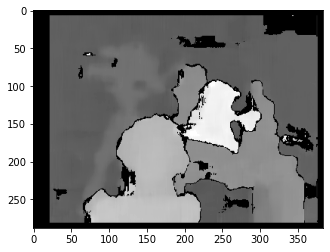

In [4]:
ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''

def write_ply(fn, verts, colors):
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    verts = np.hstack([verts, colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

imgL = cv.imread('./img/tsukuba_l.png',0)
imgR = cv.imread('./img/tsukuba_r.png',0)
stereo = cv.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(imgL,imgR)
plt.imshow(disparity,'gray')
plt.show()

# print('generating 3d point cloud...',)
h, w = imgL.shape[:2]
f = 0.8 * w  # guess for focal length
Q = np.float32([[1, 0, 0, -0.5 * w],
                [0, -1, 0, 0.5 * h],  # turn points 180 deg around x-axis,
                [0, 0, 0, -f],  # so that y-axis looks up
                [0, 0, 1, 0]])
points = cv.reprojectImageTo3D(disparity, Q)
colors = cv.cvtColor(imgL, cv.COLOR_BGR2RGB)
mask = disparity > disparity.min()
out_points = points[mask]
out_colors = colors[mask]
write_ply('out.ply', out_points, out_colors)
#append_ply_array(out_points, out_colors)

# Feature-Basics: Difference of Gaussians

Text(0.5, 1.0, 'Blur 3x3 - Blur 5x5')

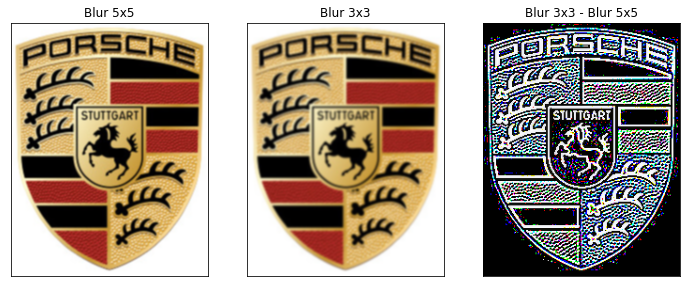

In [5]:
img = cv.cvtColor(cv.imread('./img/Porsche_Wappen.jpg'), cv.COLOR_BGR2RGB)

# first blur images
img_blur3 = cv.GaussianBlur(img,(3,3),0)
img_blur5 = cv.GaussianBlur(img,(5,5),0)

# then subtract
img_subt = img_blur3 - img_blur5

plt.figure(figsize=(12,6)); 
plt.subplot(1,3,1); plt.imshow(img_blur3); plt.xticks([]); plt.yticks([]); plt.title('Blur 5x5')
plt.subplot(1,3,2); plt.imshow(img_blur5); plt.xticks([]); plt.yticks([]); plt.title('Blur 3x3')
plt.subplot(1,3,3); plt.imshow(img_subt); plt.xticks([]); plt.yticks([]); plt.title('Blur 3x3 - Blur 5x5')

# Blob Detection explained

interactive(children=(FloatSlider(value=0.75, description='sigma', max=2.25, min=-0.75), Output()), _dom_class…

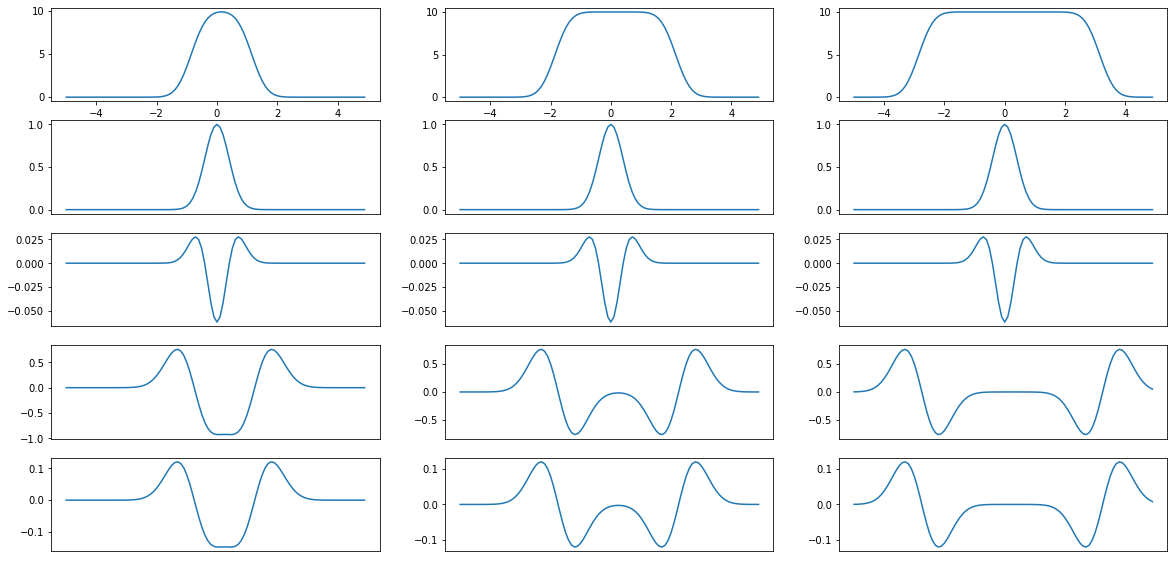

In [9]:
def calc_gaussians(sigma = 1 / np.sqrt(2*np.pi)):
    x = np.arange(-5,5,0.1)
    y1_rect = np.zeros(100)
    y2_rect = np.zeros(100)
    y3_rect = np.zeros(100)    
    y_gauss = scipy.stats.norm(0, sigma)
    #y_gauss_2nd = np.diff(y_gauss.pdf(x),2,prepend=0,append=0) # 2nd derivative and pad with 0s
    y_gauss_2nd = np.diff(y_gauss.pdf(x),2) # 2nd derivative and pad with 0s

    y1_rect[(x > -1) & (x < 1)] = 1
    y2_rect[(x > -2) & (x < 2)] = 1
    y3_rect[(x > -3) & (x < 3)] = 1

    y1 = np.convolve(y_gauss.pdf(x), y1_rect, mode='same')
    #y1 = y1 / np.max(y1)
    y2 = np.convolve(y_gauss.pdf(x), y2_rect, mode='same')
    #y2 = y2 / np.max(y2)
    y3 = np.convolve(y_gauss.pdf(x), y3_rect, mode='same')
    #y3 = y3 / np.max(y3)

    y1_conv_2nd = np.convolve(y1, y_gauss_2nd, mode='same')
    y2_conv_2nd = np.convolve(y2, y_gauss_2nd, mode='same')
    y3_conv_2nd = np.convolve(y3, y_gauss_2nd, mode='same')

    y1_conv_2nd_norm = y1_conv_2nd * sigma * sigma
    y2_conv_2nd_norm = y2_conv_2nd * sigma * sigma
    y3_conv_2nd_norm = y3_conv_2nd * sigma * sigma

    plt.figure(figsize=[20,10])
    # 1st row: show functions y = gauss conv. rect
    plt.subplot(5,3,1)
    plt.plot(x, y1, label='y1')    
    plt.subplot(5,3,2)
    plt.plot(x, y2, label='y2')    
    plt.subplot(5,3,3)
    plt.plot(x, y3, label='y3')    

    # 2nd row: gaussian
    plt.subplot(5,3,4)
    plt.plot(x, y_gauss.pdf(x), label='y1')
    plt.xticks([])
    plt.subplot(5,3,5)    
    plt.plot(x, y_gauss.pdf(x), label='y2')
    plt.xticks([])
    plt.subplot(5,3,6)    
    plt.plot(x, y_gauss.pdf(x), label='y3')
    plt.xticks([])
    
    # 3rd row: 2nd derivative of gaussian
    plt.subplot(5,3,7)
    plt.plot(y_gauss_2nd, label='y1')
    plt.xticks([])
    plt.subplot(5,3,8)
    plt.plot(y_gauss_2nd, label='y2')
    plt.xticks([])
    plt.subplot(5,3,9)
    plt.plot(y_gauss_2nd, label='y3')
    plt.xticks([])

    # 4th row: 2nd derivative gaussian conv. with y
    plt.subplot(5,3,10)
    plt.plot(y1_conv_2nd, label='y1')
    plt.xticks([])
    plt.subplot(5,3,11)
    plt.plot(y2_conv_2nd, label='y2')
    plt.xticks([])
    plt.subplot(5,3,12)
    plt.plot(y3_conv_2nd, label='y3')
    plt.xticks([])

    # 5th row: normalized 2nd derivative gaussian conv. with y (by sigma squared)
    plt.subplot(5,3,13)
    plt.plot(y1_conv_2nd_norm, label='y1')
    plt.xticks([])
    plt.subplot(5,3,14)
    plt.plot(y2_conv_2nd_norm, label='y2')
    plt.xticks([])
    plt.subplot(5,3,15)
    plt.plot(y3_conv_2nd_norm, label='y3')
    plt.xticks([])
    plt.show()

#slider_thresh1 = widgets.IntSlider()
slider_sigma = widgets.FloatSlider(value=0.75,
                             min=0.01, max=1.50,
                             step=0.01, orientation='horizontal',
                             readout=True, readoutformat='.2f',
                             continuous_update=False)

interact(calc_gaussians, sigma = slider_sigma.value)

calc_gaussians()
